## Sentiment Analysis on the cleaned news articles

### Sentiment classification using Vader

In [ ]:
# !pip install vaderSentiment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sys
import bs4
import nltk.corpus  
from nltk.text import Text
import spacy
from pandarallel import pandarallel
import multiprocessing
import warnings
warnings.filterwarnings('ignore')
import ipywidgets as widgets
widgets.IntSlider()

pd.set_option('max_colwidth', 200)

2023-05-21 23:32:35.749722: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 23:32:40.229966: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-21 23:32:40.230195: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [2]:
pandarallel.initialize(nb_workers = 60, use_memory_fs = False)

INFO: Pandarallel will run on 60 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
%%time
df_sent = pd.read_parquet('data_to_sentiment.parquet', engine = 'pyarrow')
df_sent.head(2)

CPU times: user 47.9 s, sys: 8.5 s, total: 56.4 s
Wall time: 48.1 s


,date,month,year,quarter,day,dayofwk,title,text,title_clean,text_clean,title_tokens,text_tokens,title_len,text_len
0,2021-03-18,3,2021,2021Q1,18,3,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,\n\nArtificial intelligence improves parking efficiency in Chinese cities - People's Daily Online\n\nHome\nChina Politics\nForeign Affairs\nOpinions\nVideo: We Are China\nBusiness\nMilitary\nWorld...,Artificial intelligence improves parking efficiency Chinese cities People Daily Online,Artificial intelligence improves parking efficiency Chinese cities People Daily Online Home China Politics Foreign Affairs Opinions Video We Are China Business Military World Society Culture Trave...,"[Artificial, intelligence, improves, parking, efficiency, Chinese, cities, People, Daily, Online]","[Artificial, intelligence, improves, parking, efficiency, Chinese, cities, People, Daily, Online, Home, China, Politics, Foreign, Affairs, Opinions, Video, We, Are, China, Business, Military, Worl...",10,705
1,2020-02-27,2,2020,2020Q1,27,3,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,"\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament\n \n\nSkip to content\n\t\t\tThursday, February 27, 2020\t\t\n\nLatest:\n\n\n...",Children With Autism Saw Their Learning Social Skills Boosted After Playing With This AI Robot News Parliament,"Children With Autism Saw Their Learning Social Skills Boosted After Playing With This AI Robot News Parliament Skip Thursday , February 27 , 2020 Latest Mansplaining conferences How forestall Drax...","[Children, With, Autism, Saw, Their, Learning, Social, Skills, Boosted, After, Playing, With, This, AI, Robot, News, Parliament]","[Children, With, Autism, Saw, Their, Learning, Social, Skills, Boosted, After, Playing, With, This, AI, Robot, News, Parliament, Skip, content, Thursday, ,, February, 27, ,, 2020, Latest, Mansplai...",17,1208


#### Initialize the Vader Analyzer

In [4]:
#Load the SentimentIntensityAnalyzer object from the VADER package
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Create a handle to the SentimentIntensityAnalyzer object
analyzer = SentimentIntensityAnalyzer()

#function that outputs the sentiment ratings
def print_sentiment_ratings(sentence):
    sent = analyzer.polarity_scores(sentence)
    print("{}".format(sent))

In [5]:
#Checking on a sample first

df_sample = df_sent.sample(n = 1000,replace = False)

In [6]:
analyzer.polarity_scores(list(df_sample['text_clean'])[0])["compound"]

0.9984

In [7]:
print_sentiment_ratings(list(df_sample['text_clean'])[0])

{'neg': 0.079, 'neu': 0.784, 'pos': 0.137, 'compound': 0.9984}


In [8]:
%%time
df_sample['sentiment'] = df_sample['text_clean'].parallel_apply(lambda x: analyzer.polarity_scores(x)["compound"])

CPU times: user 216 ms, sys: 3.85 s, total: 4.07 s
Wall time: 5.65 s


In [9]:
df_sample['sentiment'].describe()

count    1000.000000
mean        0.865347
std         0.454865
min        -0.999700
25%         0.990775
50%         0.997350
75%         0.999000
max         0.999900
Name: sentiment, dtype: float64

In [10]:
df_sample['sentiment_score'] = df_sample['sentiment']
# Create a positive / negative sentiment variable
df_sample['sentiment'] = np.where(df_sample['sentiment_score'].astype(np.float) > 0, 'Positive', 'Negative')
df_sample['sentiment'] = np.where(df_sample['sentiment_score'].astype(np.float) == 0, 'Neutral', df_sample['sentiment'])
df_sample.head(2)

,date,month,year,quarter,day,dayofwk,title,text,title_clean,text_clean,title_tokens,text_tokens,title_len,text_len,sentiment,sentiment_score
99279,2021-08-13,8,2021,2021Q3,13,4,Big Tech’s stranglehold on artificial intelligence must be regulated,\n\nBig Tech’s stranglehold on artificial intelligence must be regulated\nSkip to main content\n×\n\nHomeEconomyStocksAnalysisWorld+BizSportsGlitzFeaturesVideosLong ReadEpaperMoreCOVID-19Banglades...,Big Techs stranglehold artificial intelligence regulated,Big Techs stranglehold artificial intelligence regulated Skip main HomeEconomyStocksAnalysisWorld BizSportsGlitzFeaturesVideosLong ReadEpaperMoreCOVID 19BangladeshInfographInterviewsOffbeatThought...,"[Big, Techs, stranglehold, artificial, intelligence, must, regulated]","[Big, Techs, stranglehold, artificial, intelligence, must, regulated, Skip, main, content, HomeEconomyStocksAnalysisWorld, BizSportsGlitzFeaturesVideosLong, ReadEpaperMoreCOVID, 19BangladeshInfogr...",7,1752,Positive,0.9984
40230,2020-05-19,5,2020,2020Q2,19,1,Google backs off on AI for oil and gas extraction | The Seattle Times,\n\nGoogle backs off on AI for oil and gas extraction | The Seattle Times\n \nSkip to content\nMenu\nCoronavirus\nLocal News\n\nTraffic Lab\nCrime\nLocal Politics\nEducation\nEducation Lab\nEastsi...,Google backs AI oil gas extraction The Seattle Times,Google backs AI oil gas extraction The Seattle Times Skip Menu Coronavirus Local News Traffic Lab Crime Local Politics Education Education Lab Eastside Health Data Project Homeless Times Watchdog ...,"[Google, backs, AI, oil, gas, extraction, The, Seattle, Times]","[Google, backs, AI, oil, gas, extraction, The, Seattle, Times, Skip, content, Menu, Coronavirus, Local, News, Traffic, Lab, Crime, Local, Politics, Education, Education, Lab, Eastside, Health, Dat...",9,804,Positive,0.9025


Text(0.5, 1.0, 'Distribution of Sentiments in the Sampled Data')

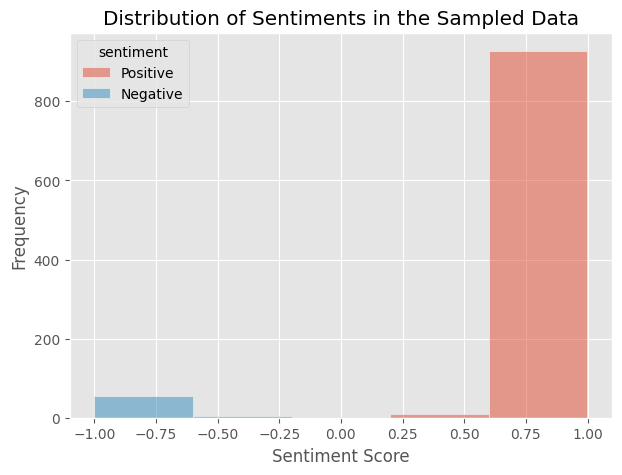

In [11]:
#Plotting the distribution of the sentiments
plt.style.use("ggplot")
plt.figure(figsize = (7,5))
sns.histplot(data = df_sample, x = 'sentiment_score', bins = 5, hue = 'sentiment' )
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.title("Distribution of Sentiments in the Sampled Data")

In [12]:
%%time
##Apply the Vader Analyzer to the complete data to check if the distribution gets more evenly distributed
df_sent['sentiment_score'] = df_sent['text_clean'].parallel_apply(lambda x : analyzer.polarity_scores(x)["compound"])

CPU times: user 1.07 s, sys: 5.25 s, total: 6.33 s
Wall time: 3min 51s


In [13]:
df_sent['sentiment'] = np.where(df_sent['sentiment_score']>0, "Positive","Negative")
df_sent['sentiment'] = np.where(df_sent['sentiment_score']==0, "Neutral",df_sent['sentiment'])

df_sent.head(2)

,date,month,year,quarter,day,dayofwk,title,text,title_clean,text_clean,title_tokens,text_tokens,title_len,text_len,sentiment_score,sentiment
0,2021-03-18,3,2021,2021Q1,18,3,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,\n\nArtificial intelligence improves parking efficiency in Chinese cities - People's Daily Online\n\nHome\nChina Politics\nForeign Affairs\nOpinions\nVideo: We Are China\nBusiness\nMilitary\nWorld...,Artificial intelligence improves parking efficiency Chinese cities People Daily Online,Artificial intelligence improves parking efficiency Chinese cities People Daily Online Home China Politics Foreign Affairs Opinions Video We Are China Business Military World Society Culture Trave...,"[Artificial, intelligence, improves, parking, efficiency, Chinese, cities, People, Daily, Online]","[Artificial, intelligence, improves, parking, efficiency, Chinese, cities, People, Daily, Online, Home, China, Politics, Foreign, Affairs, Opinions, Video, We, Are, China, Business, Military, Worl...",10,705,0.9978,Positive
1,2020-02-27,2,2020,2020Q1,27,3,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,"\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament\n \n\nSkip to content\n\t\t\tThursday, February 27, 2020\t\t\n\nLatest:\n\n\n...",Children With Autism Saw Their Learning Social Skills Boosted After Playing With This AI Robot News Parliament,"Children With Autism Saw Their Learning Social Skills Boosted After Playing With This AI Robot News Parliament Skip Thursday , February 27 , 2020 Latest Mansplaining conferences How forestall Drax...","[Children, With, Autism, Saw, Their, Learning, Social, Skills, Boosted, After, Playing, With, This, AI, Robot, News, Parliament]","[Children, With, Autism, Saw, Their, Learning, Social, Skills, Boosted, After, Playing, With, This, AI, Robot, News, Parliament, Skip, content, Thursday, ,, February, 27, ,, 2020, Latest, Mansplai...",17,1208,0.9991,Positive


Text(0.5, 1.0, 'Distribution of Sentiments in the Overall Data')

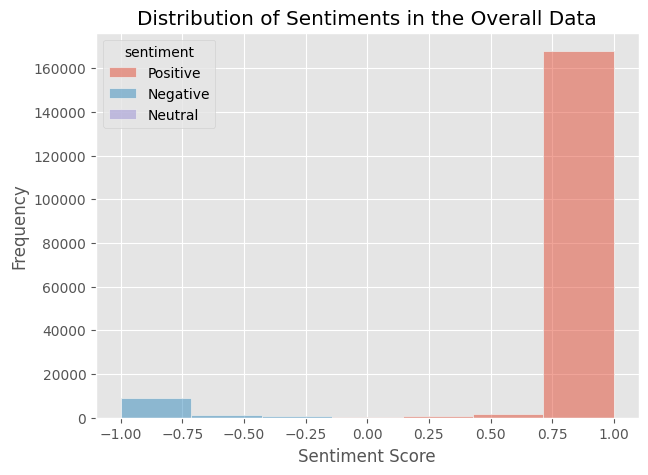

In [14]:
#Plotting the distribution of the sentiments
plt.style.use("ggplot")
plt.figure(figsize = (7,5))
sns.histplot(data = df_sent, x = 'sentiment_score', bins = 7, hue = 'sentiment' )
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.title("Distribution of Sentiments in the Overall Data")

In [15]:
df_sample.sentiment.value_counts()

Positive    939
Negative     61
Name: sentiment, dtype: int64

In [16]:
df_sent.sentiment.value_counts()

Positive    170643
Negative     11280
Neutral         35
Name: sentiment, dtype: int64

In [17]:
df_sent.columns

Index(['date', 'month', 'year', 'quarter', 'day', 'dayofwk', 'title', 'text',
       'title_clean', 'text_clean', 'title_tokens', 'text_tokens', 'title_len',
       'text_len', 'sentiment_score', 'sentiment'],
      dtype='object')

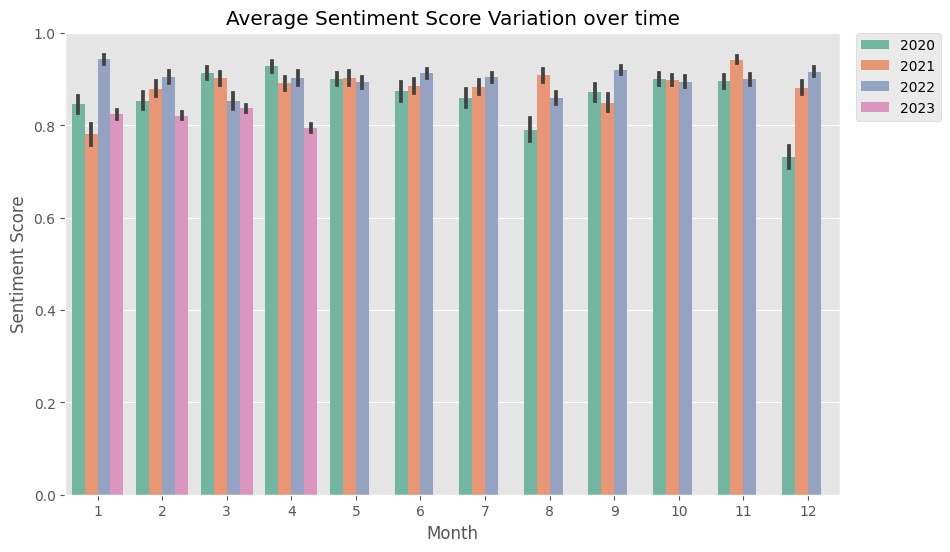

In [18]:
#Plotting the sentiments over time
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data = df_sent, x = 'month', y= 'sentiment_score', hue = "year", palette = "Set2", ax=ax)
plt.legend(bbox_to_anchor=(1.02,1), loc=2, borderaxespad =0.)
plt.xlabel("Month")
plt.ylabel("Sentiment Score")
plt.title("Average Sentiment Score Variation over time")
plt.show()

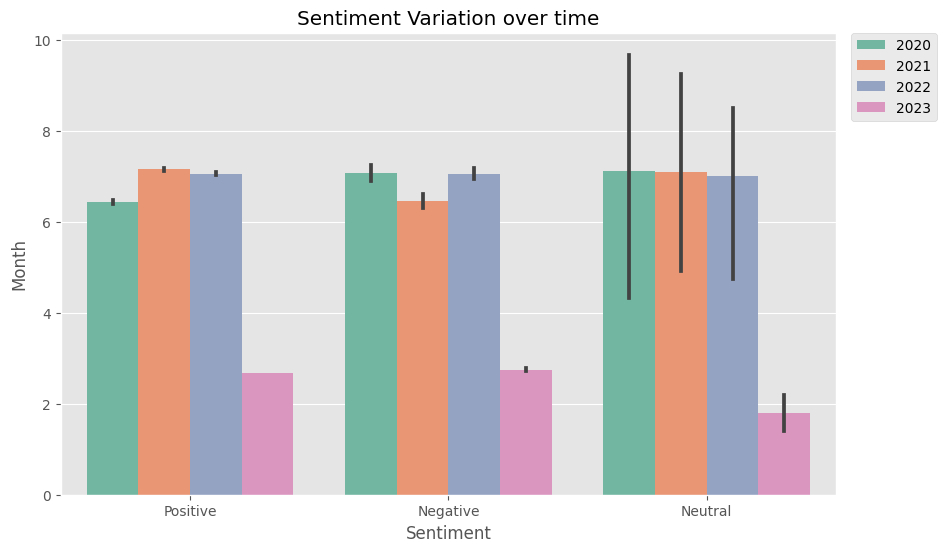

In [19]:
#Plotting the sentiments over time
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data = df_sent, y = 'month', x= 'sentiment', hue = "year", palette = "Set2", ax=ax)
plt.legend(bbox_to_anchor=(1.02,1), loc=2, borderaxespad =0.)
plt.xlabel("Sentiment")
plt.ylabel("Month")
plt.title("Sentiment Variation over time")
plt.show()

In [20]:
import datetime
import time
import pytz
datetime.datetime.now(pytz.timezone('US/Central')).strftime("%a, %d %B %Y %H:%M:%S")

'Sun, 21 May 2023 18:38:20'